In [102]:
import os 

os.chdir('E://bond-dex/bond-amm-research/')

In [103]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 

In [104]:
class Rate(): 
    
    def __init__(self, T, N, r0, a, b, sigma): 
        self.T = T
        self.N = N 
        self.r0 = r0 
        self.a = a 
        self.b = b 
        self.sigma = sigma 
        self.dt = T / N
        
    def cir(self): 
        
        out = np.zeros(self.N)
        
        out[0] = r0 
        
        for i in range(self.N - 1):
            dr_i = self.a * (self.b - out[i]) * self.dt + self.sigma * np.sqrt(out[i]) * np.random.normal() * np.sqrt(self.dt)
            out[i + 1] = out[i] + dr_i
        
        return out

In [105]:
def calculate_x(r, r_min, r_max, A, t, T): 
    tau = T - t 
    return A * (r - r_min) * np.exp(-(r_max - r)**2 / (2 * (r_max - r_min)) * tau)


def calculate_y(r, r_min, r_max, A, t, T): 
    tau = T - t 
    return A * (r_max - r) * np.exp(-(r_max - r)**2 / (2 * (r_max - r_min)) * tau - r * tau)

In [106]:
rate = Rate(T=T, N=N, r0=r0, a=a, b=b, sigma=sigma)

r = rate.cir()

In [107]:
r_df = pd.read_csv('data/input/interest_rate/eth_simulated_rate1.csv')

r = r_df.rate.values[:N]

In [108]:
T = 1
N = int(T * 365 * 24 * 60)

sigma=0.05
a=5
b=0.05

r0 = r[0]

y0 = 0.5

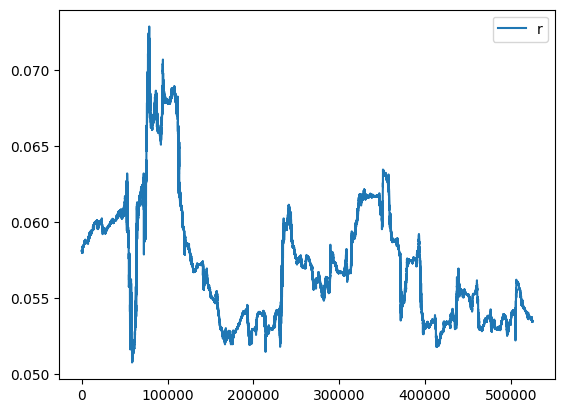

In [109]:
plt.plot(r, label='r')

plt.legend()

In [110]:
r_min = np.quantile(r, 0.005)
r_max = np.quantile(r, 0.995)

In [111]:
A = y0 / calculate_y(r0, r_min, r_max, A=1, t=0, T=T)

In [112]:
x = calculate_x(r, r_min, r_max, A=A, t=np.arange(0, N) * T / N, T=T)
y = calculate_y(r, r_min, r_max, A=A, t=np.arange(0, N) * T / N, T=T)

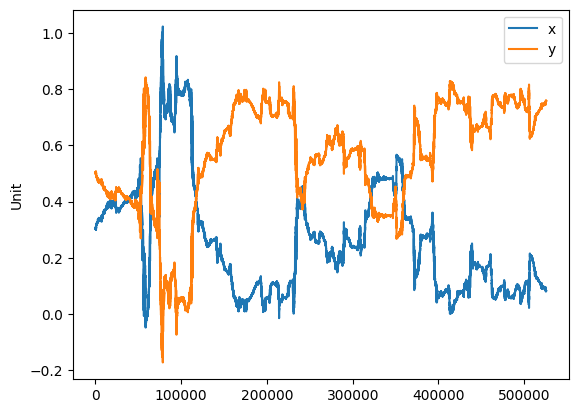

In [113]:
plt.plot(x, label='x')
plt.plot(y, label='y')

plt.ylabel('Unit')

plt.legend()

In [114]:
def exp(x, n=5):
 
    # initialize sum of series
    e = 1.0
    for i in range(n, 0, -1):
        e = 1 + x * e / i
    
    return e

In [115]:
def calculate_x_approx(r, r_min, r_max, A, t, T): 
    tau = T - t 
    return A * (r - r_min) * exp(-(r_max - r)**2 / (2 * (r_max - r_min)) * tau)


def calculate_y_approx(r, r_min, r_max, A, t, T): 
    tau = T - t 
    return A * (r_max - r) * exp(-(r_max - r)**2 / (2 * (r_max - r_min)) * tau - r * tau)

In [116]:
def f_x(x, r, r_min, r_max, A, t, T):
    return calculate_x_approx(r, r_min, r_max, A, t, T) - x

def f_y(y, r, r_min, r_max, A, t, T):
    return calculate_y_approx(r, r_min, r_max, A, t, T) - y

def derive_x(r, A, tau, r_max, r_min):
    return A * exp(-1/2 * (r_max - r)**2 / (r_max - r_min) * tau) \
          + A * (r - r_min) * exp(-1/2 * (r_max-r)**2/(r_max - r_min) * tau) * (tau * (r_max - r) / (r_max - r_min))

def derive_y(r, A, tau, r_max, r_min):
    
    e = exp(-1/2 * (r_max - r)**2 / (r_max - r_min) * tau - r * tau)
    
    return -A * e + A * (r_max - r) * e * (-(r - r_min) / (r_max - r_min) * tau)


def calculate_r_by_x(x, A, t, T, r_max, r_min, r0, n_iterations=10):
    
    r = [r0]
    tau = T - t

    for _ in range(n_iterations): 
        r_next = r[-1] - f_x(x, r[-1], r_min, r_max, A, t, T) / derive_x(r[-1], A, tau, r_max, r_min)
        r.append(r_next)
    
    return r[-1]

def calculate_r_by_y(y, A, t, T, r_max, r_min, r0, n_iterations=10):
  
    r = [r0]
    tau = T - t

    for _ in range(n_iterations): 
        r_next = r[-1] - f_y(y, r[-1], r_min, r_max, A, t, T) / derive_y(r[-1], A, tau, r_max, r_min)
        r.append(r_next)
    
    return r[-1]

In [55]:
sample_id = np.random.choice(N)

print(y[sample_id])
print(y[sample_id-1])

print(r[sample_id])
print(r[sample_id-1])

print(calculate_r_by_y(y[sample_id], A, sample_id * T/N, T, r_max, r_min, r0, n_iterations=10))
print(f_y(y[sample_id], r[sample_id], r_min, r_max, A, sample_id * T/N, T))

print(derive_y(r[sample_id], A, T - sample_id * T/N, r_max, r_min))

print((y[sample_id] - y[sample_id - 1]) / (r[sample_id] - r[sample_id - 1]))
(calculate_y(r[sample_id], r_min, r_max, A, sample_id * T/N, T) - calculate_y(r[sample_id]+0.000001, r_min, r_max, A, sample_id * T/N, T)) / 0.000001

1.3069495350336402
1.3068476876541677
0.0529439593272509
0.0529452000645329
0.05294395932716193
-7.292166870342953e-12
-81.96507475686322
-82.08617646147769


81.96509653290995

In [56]:
from tqdm import tqdm

In [116]:
r_prox = []

for k in tqdm(range(len(r))):
    r_prox.append(calculate_r_by_y(y[k], A, k * T/N, T, r_max, r_min, r0=0.05, n_iterations=10))

100%|████████████████████████████████████████████████████████████████████████| 525600/525600 [01:04<00:00, 8087.30it/s]


In [117]:
r_prox = np.array(r_prox)

In [118]:
np.abs(r - r_prox).mean(), np.abs(r - r_prox).std()

(4.687294782187842e-17, 8.108962388339349e-17)

In [119]:
x[0], y[0]

(1.0, 0.2569804820712932)

## Check whether the functions have multiple root elements

In [120]:
def select_sample_r():
    sample_id = np.random.choice(N)
    xf = x[sample_id]
    r_grid = np.linspace(0, 1, 100)
    f = f_x(x[sample_id], r_grid, r_min, r_max, A, sample_id * T/N, T)
    return xf, r_grid, f

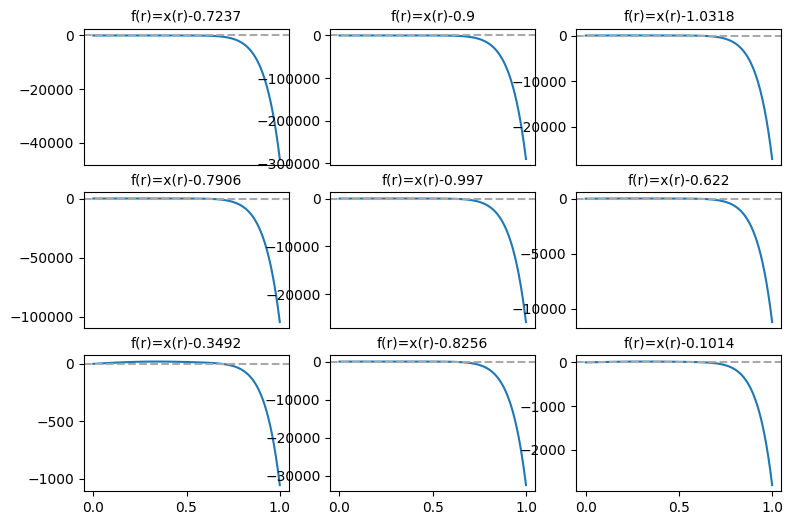

In [121]:
fig, axs = plt.subplots(3, 3, figsize=(9, 6))

for i in range(3):
    for j in range(3):

        xf, r_grid, f1 = select_sample_r()

        axs[i, j].plot(r_grid, f1)
        axs[i, j].set_title(f"f(r)=x(r)-{round(xf, 4)}", fontsize=10)
        
        axs[i, j].axhline(0, xmin=0, xmax=1, color='darkgrey', linestyle='dashed')
        
        if i != 2: 
            axs[i, j].set_xticks([])

# Simulate from the initial state to maturity

In [117]:
## the initial state

y0 = y[0] 
r0 = r[0]
T = 1
N = 365 * 24 * 60

r_min = r_min 
r_max = r_max

$$
    y = A \times (r_{max} - r) \times e^{-\frac{(r_{max} - r)^2}{2(r_{max} - r_{min})}\tau - r\tau}
$$

In [118]:
## get A and x0

A = y0 / calculate_y_approx(r0, r_min, r_max, 1, 0, T)

print(f'initial A: {A}')

x0 = calculate_x_approx(r0, r_min, r_max, A, 0, T)

print(f'initial x: {x0}')

initial A: 48.39198410253065
initial x: 0.3069955770439887


<font color='red'>**Sample trades over time**</font>

In [119]:
dx = np.diff(x)
dy = np.diff(y)

In [120]:
def sample_trade(dx, dy):
    N = len(dx)
    
    trade_side = np.random.binomial(n=1, p=0.5, size=N)
    
    trade_size = np.where(trade_side == 1, dy, dx)
    
    return trade_side, trade_size

In [121]:
trade_sides, trade_volumes = sample_trade(dx, dy)

### Save simulated trade to csv

In [122]:
trade_df = pd.DataFrame({'dx': dx, 'dy': dy})
trade_df['action'] = trade_df.dy.apply(lambda x: 'lend' if x > 0 else 'borrow')
trade_df = trade_df.reset_index().rename(columns={'dy': 'cash_volume', 'index': 'timestamp'})[['timestamp', 'action', 'cash_volume']]
trade_df.cash_volume = np.abs(trade_df.cash_volume)
trade_df.timestamp += 1

In [123]:
trade_df.describe()

,timestamp,cash_volume
count,525599.000000,5.255990e+05
mean,262800.000000,4.689129e-04
std,151727.506405,1.046501e-03
min,1.000000,1.279229e-10
25%,131400.500000,4.894648e-05
50%,262800.000000,1.562513e-04
75%,394199.500000,4.351376e-04
max,525599.000000,2.707918e-02


In [124]:
trade_df.to_csv('data/input/simulated_eth_trade1.csv', index=False)

In [126]:
trade_df.to_csv('E:/bond-dex/bond-amm-simulation/sources/input/actor_trade/simulated_eth_trade1.csv', index=False)

In [94]:
trade_df = pd.read_csv('data/input/simulated_eth_trade1.csv')

In [95]:
LENGTH = 24 * 60

In [96]:
trade_df['day'] = (trade_df.timestamp / LENGTH).astype('int') * LENGTH
trade_df['net_volume'] = trade_df.apply(lambda row: row['cash_volume'] if row['action'] == 'lend'
                                                       else -row['cash_volume'], axis=1)

In [97]:
trade_df = trade_df[trade_df.day < 180 * LENGTH]

In [98]:
agg_trade = trade_df.groupby(['day', 'action'], as_index=False).agg({'net_volume': 'sum'})

In [99]:
net_trade = agg_trade.groupby('day', as_index=False).agg({'net_volume': 'sum'})

In [100]:
agg_trade['cum_volume'] = agg_trade.groupby('action')['net_volume'].transform(lambda x: np.cumsum(x))

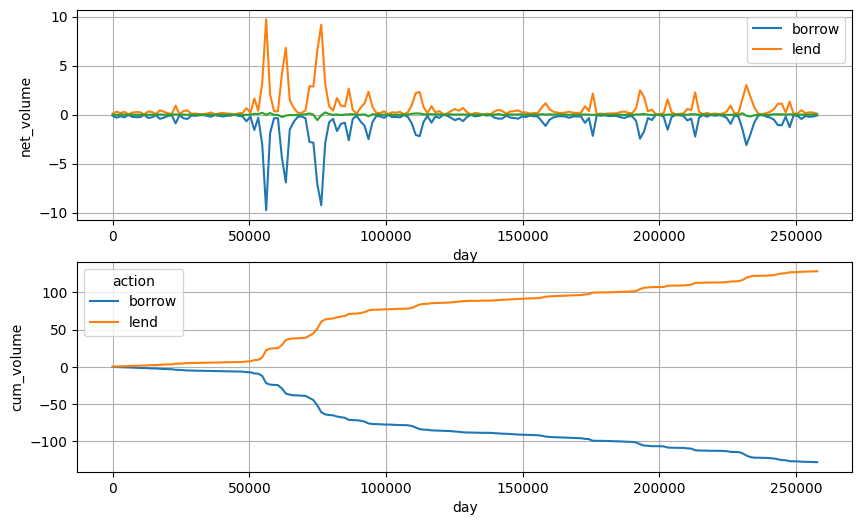

In [101]:
fig, axs = plt.subplots(2, 1, figsize=(10, 6))

sns.lineplot(data=agg_trade, x='day', y='net_volume', hue='action', 
             ax=axs[0])

sns.lineplot(data=net_trade, x='day', y='net_volume', 
             ax=axs[0])

axs[0].grid(True)

sns.lineplot(data=agg_trade, x='day', y='cum_volume', hue='action', 
             ax=axs[1])
axs[1].grid(True)

plt.show()

### Simulation

In [28]:
y_simulated = [y0]
r_simulated = [r0]
x_simulated = [x0]

for i, (side, size) in tqdm(enumerate(zip(trade_sides, trade_volumes))):
    t = i * T/N
    if side == 1:
        y_i = y_simulated[-1] + size 
        r_i = calculate_r_by_y(y_i, A, t, T, r_max, r_min, r0)
        x_i = calculate_x(r_i, r_min, r_max, A, t, T)
    else: 
        x_i = x_simulated[-1] + size
        r_i = calculate_r_by_x(x_i, A, t, T, r_max, r_min, r0)
        y_i = calculate_y(r_i, r_min, r_max, A, t, T)
    
    y_simulated.append(y_i)
    x_simulated.append(x_i)
    r_simulated.append(r_i)

525599it [00:46, 11206.58it/s]


In [29]:
y_simulated = np.array(y_simulated)
r_simulated = np.array(r_simulated)
x_simulated = np.array(x_simulated)

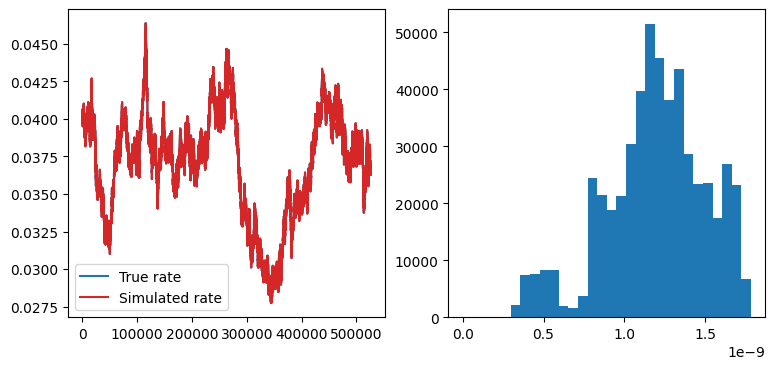

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4))

axs[0].plot(r, color='tab:blue', label='True rate')
axs[0].plot(r_simulated, color='tab:red', label='Simulated rate')

axs[1].hist(r - r_simulated, bins=30)

axs[0].legend()